In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as T

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCHS = 30
TRANSFORMS = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,))
]) # mean/std for grayscales

In [43]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = TRANSFORMS,
)
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = TRANSFORMS) # mean/std for grayscale

In [44]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

In [45]:
for X, y in train_loader:
    print(f'Batch size is {X.shape[0]} \n Number of colors is {X.shape[1]} \n Height: {X.shape[2]}, Weight: {X.shape[3]}')
    break

Batch size is 64 
 Number of colors is 1 
 Height: 28, Weight: 28


In [46]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [47]:
model = MnistModel().to(DEVICE)
model

MnistModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # weights optimized after loss calc

In [49]:
train_losses = []
def train(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f'Average Loss: {avg_loss:>0.2f}')

In [50]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)

            pred = model(X)
            test_loss += loss_fn(pred, y).item() # item() - get num from tensor
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # pred.argmax(1) - max predicted for class and boolean compare to y

    test_loss /= num_batches # avg
    correct /= size # avg

    print(f'Test Accuracy: {(correct * 100):>0.2f}%, Avg Loss: {test_loss:>0.2f}')

In [51]:
for e in range(EPOCHS):
    print(f'Epoch {e+1}')
    train(dataloader = train_loader, model = model, loss_fn = loss_fn, optimizer = optimizer)
    test(dataloader = test_loader, model = model, loss_fn = loss_fn)

Epoch 1
Average Loss: 0.48
Test Accuracy: 85.67%, Avg Loss: 0.40
Epoch 2
Average Loss: 0.36
Test Accuracy: 86.42%, Avg Loss: 0.37
Epoch 3
Average Loss: 0.33
Test Accuracy: 86.02%, Avg Loss: 0.38
Epoch 4
Average Loss: 0.30
Test Accuracy: 86.94%, Avg Loss: 0.35
Epoch 5
Average Loss: 0.28
Test Accuracy: 86.97%, Avg Loss: 0.36
Epoch 6
Average Loss: 0.26
Test Accuracy: 88.12%, Avg Loss: 0.34
Epoch 7
Average Loss: 0.25
Test Accuracy: 87.62%, Avg Loss: 0.34
Epoch 8
Average Loss: 0.23
Test Accuracy: 88.70%, Avg Loss: 0.33
Epoch 9
Average Loss: 0.22
Test Accuracy: 87.90%, Avg Loss: 0.35
Epoch 10
Average Loss: 0.21
Test Accuracy: 87.86%, Avg Loss: 0.37
Epoch 11
Average Loss: 0.20
Test Accuracy: 87.85%, Avg Loss: 0.37
Epoch 12
Average Loss: 0.19
Test Accuracy: 87.94%, Avg Loss: 0.38
Epoch 13
Average Loss: 0.18
Test Accuracy: 88.89%, Avg Loss: 0.35
Epoch 14
Average Loss: 0.17
Test Accuracy: 88.55%, Avg Loss: 0.37
Epoch 15
Average Loss: 0.16
Test Accuracy: 88.72%, Avg Loss: 0.38
Epoch 16
Average Lo

In [58]:
torch.save(model.state_dict(), '30_epochs.pth')

In [59]:
model.load_state_dict(torch.load('30_epochs.pth', weights_only = True))

<All keys matched successfully>

In [60]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [61]:
model.eval()
X, y = test_data[0]
with torch.no_grad():
    X = X.unsqueeze(0).to(DEVICE)
    pred = model(X)
    predicted = classes[pred[0].argmax().item()]
    actual = classes[y]
    print(f'Predicted: {predicted}, Actual: {actual}')

Predicted: Ankle boot, Actual: Ankle boot


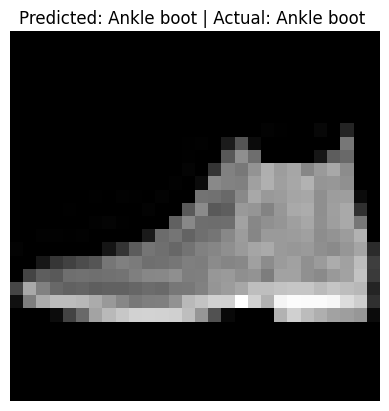

In [62]:
plt.imshow(X.squeeze(), cmap='gray') # squeeze from [1, 28, 28] to shape 28*28 
plt.title(f'Predicted: {predicted} | Actual: {actual} ')
plt.axis('off')
plt.show()

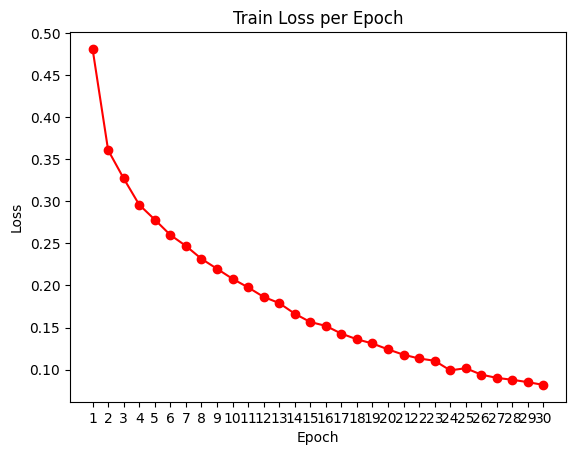

In [63]:
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, train_losses, marker='o', color='r')
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.show()